# Salary Disparity Analysis

## Exploratory data analysis

In [1]:
#import packages used in the assignment
!pip install a-world-of-countries
!pip install pingouin
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import awoc
from scipy import stats
import pingouin as pg

In [2]:
#import csv file as df
df = pd.read_csv('clean_kaggle_data.csv')

### Plot 1: Distribution of salaries based on continents

In [3]:
#initialize awoc package
my_world = awoc.AWOC()

#Filtering out rows that do not disclose country
df_continent_trend = df.copy()
df_continent_trend = df_continent_trend[(df_continent_trend['Q4'].str.contains('disclose my location')==False)
                                        &(df_continent_trend['Q4'].str.contains('Other')==False)]

#rename countries into strings compatible with awoc modules
df_continent_trend['Q4'] = df_continent_trend['Q4'].replace({'Iran, Islamic Republic of...':'Iran',
                                  'Hong Kong (S.A.R.)':'Hong Kong',
                                  'Viet Nam':'Vietnam',
                                  'United Kingdom of Great Britain and Northern Ireland':'United Kingdom','United States of America':'United States'})

#get new column 'continent' my applying .get_country_continent_name function
##function takes in country name and returns continent name
df_continent_trend['continent'] = df_continent_trend['Q4'].apply(my_world.get_country_continent_name)

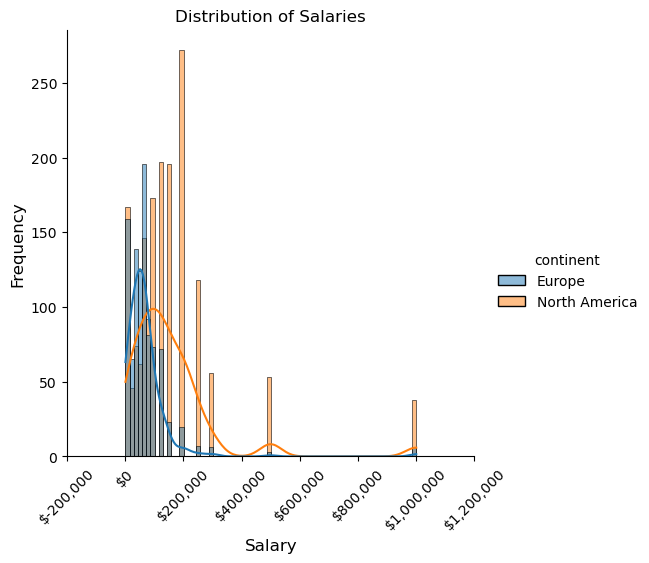

In [4]:
#Create new dataframe df_NA_EU which filters in only rows in North America or Europe
df_NA_EU = df_continent_trend[(df_continent_trend['continent']=='North America')|(df_continent_trend['continent']=='Europe')]

#Plot distribution of salaries based on continent (Europe or North America)
ax = sns.displot(data = df_NA_EU, x='Q29', kde='True', hue='continent')
ax.set(title = "Distribution of Salaries")
ax.set_xlabels('Salary',fontsize=12)
ax.set_ylabels('Frequency',fontsize=12)

ticks = ax.axes[0][0].get_xticks()
xlabels = ['$' + '{:,.0f}'.format(x) for x in ticks]
ax.set_xticklabels(xlabels,rotation = 45)


plt.show()

### Plot 2: Distribution of Salaries based on Age Groups

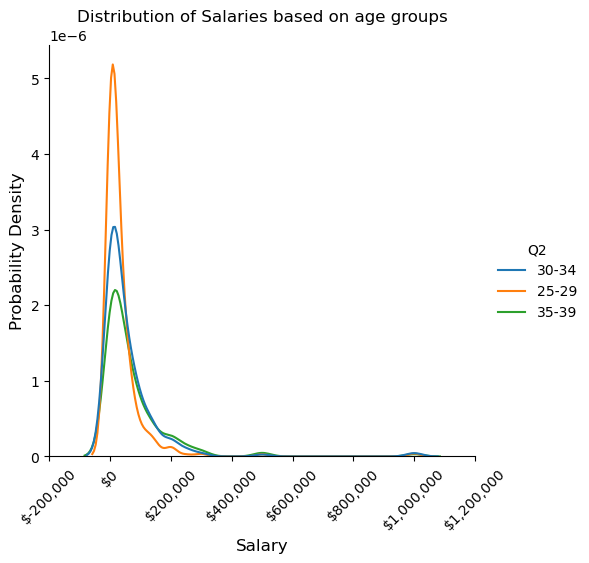

In [5]:
#Create new dataframe df_age which filters in only rows of people aged 25-29, 30-34, and 35-39
df_age = df[(df['Q2']=='25-29')|(df['Q2']=='30-34')|(df['Q2']=='35-39')]

#Plot distribution of salaries based on age (25-29, 30-34, and 35-39)
ax = sns.displot(data = df_age, x='Q29', kind = 'kde', hue='Q2')
ax.set(title = "Distribution of Salaries based on age groups")
ax.set_xlabels('Salary',fontsize=12)
ax.set_ylabels('Probability Density',fontsize=12)

ticks = ax.axes[0][0].get_xticks()
xlabels = ['$' + '{:,.0f}'.format(x) for x in ticks]
ax.set_xticklabels(xlabels,rotation = 45)

plt.show()

### Plot 3: Distribution of Salaries based on Job Titles

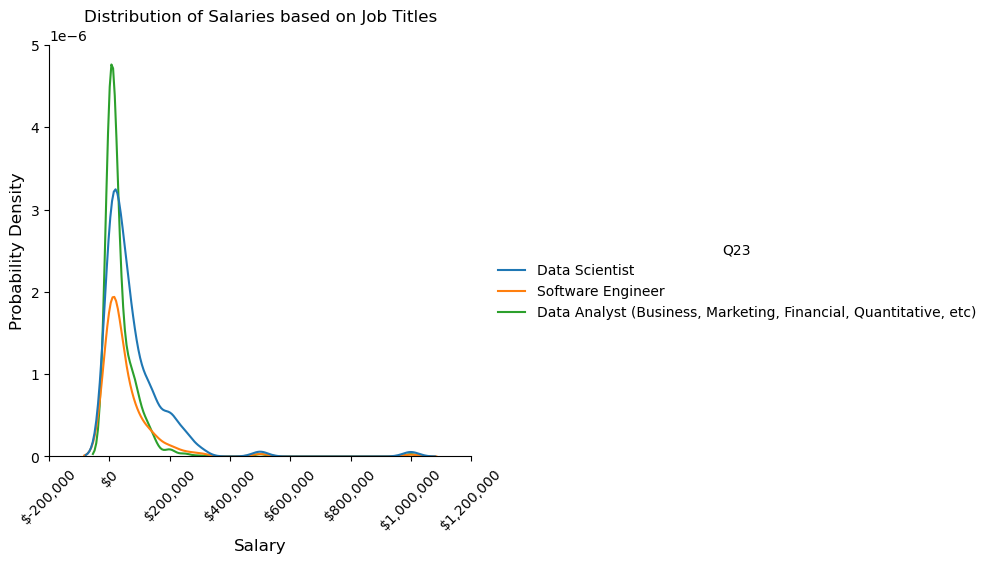

In [6]:
#Create new dataframe df_age which filters in only rows of people with job titles: Data Scientist, Software Engineer, and Data Analyst
df_job = df[(df['Q23']=='Data Scientist')|(df['Q23']=='Software Engineer')|(df['Q23']=='Data Analyst (Business, Marketing, Financial, Quantitative, etc)')]

#Plot distribution of salaries based on job title: Data Scientist, Software Engineer, and Data Analyst
ax = sns.displot(data = df_job, x='Q29', kind = 'kde', hue='Q23')
ax.set(title = "Distribution of Salaries based on Job Titles")
ax.set_xlabels('Salary',fontsize=12)
ax.set_ylabels('Probability Density',fontsize=12)

ticks = ax.axes[0][0].get_xticks()
xlabels = ['$' + '{:,.0f}'.format(x) for x in ticks]
ax.set_xticklabels(xlabels,rotation = 45)

plt.show()

## Estimating the difference between average salary of gender groups

### descriptive statistics

In [7]:
#Create a copy of df with rows 'Q3' and 'Q29' and assign it to new dataFrame df_gender_salary
df_gender_salary = df[['Q3','Q29']].copy()
df_gender_salary.head()

,Q3,Q29
0,Man,30000
1,Man,125000
2,Man,125000
3,Man,250000
4,Man,250000


In [8]:
#See value count of Men, Women, and others(Prefer not to say, prefer to self-describe, and nonbinary)
df_gender_salary['Q3'].value_counts()

Man                        6635
Woman                      1382
Prefer not to say            89
Nonbinary                    22
Prefer to self-describe       8
Name: Q3, dtype: int64

In [9]:
#Filter in only inputs from men and women
df_gender_salary = df_gender_salary[(df_gender_salary['Q3'].str.contains('Man'))
                                    | (df_gender_salary['Q3'].str.contains('Woman'))]    

In [10]:
#Calculate IQR to compute lower and upper bound to test outlier removal
Q1 = df_gender_salary['Q29'].quantile(0.25)
Q3 = df_gender_salary['Q29'].quantile(0.75)
lower_bound = Q1-1.5*(Q3-Q1)
upper_bound = Q3+1.5*(Q3-Q1)
print(f'Q1: {Q1}, Q3: {Q3}, lower_bound: {lower_bound}, upper_bound: {upper_bound}')

Q1: 4000.0, Q3: 80000.0, lower_bound: -110000.0, upper_bound: 194000.0


In [11]:
#Test outlier removal and include rows with salaries between the lower_bound and upper_bound in new dataframe df_gender_salary_filtered
df_gender_salary_filtered = df_gender_salary[(df_gender_salary['Q29'] >= lower_bound)&(df_gender_salary['Q29'] <= upper_bound)]
df_gender_salary_filtered.head()

,Q3,Q29
0,Man,30000
1,Man,125000
2,Man,125000
6,Man,100000
7,Man,40000


In [12]:
#Create dataframe male-only and female-only dataframes
df_male_salary = df_gender_salary[df_gender_salary['Q3']=='Man']
df_female_salary = df_gender_salary[df_gender_salary['Q3']=='Woman']

#Create dataframe male-only and female-only dataframes once outliers are removed
df_male_salary_filtered = df_gender_salary_filtered[df_gender_salary_filtered['Q3']=='Man']
df_female_salary_filtered = df_gender_salary_filtered[df_gender_salary_filtered['Q3']=='Woman']

In [13]:
#Get proportion of data that are outliers in male instances
male_instances = df_male_salary.shape[0] 
male_instances_filtered = df_male_salary_filtered.shape[0]
outlier_proportion_m = (male_instances-male_instances_filtered)/male_instances
print(f"outliers make up {round(outlier_proportion_m*100,2)}% of men within the dataset")

outliers make up 9.36% of men within the dataset


In [14]:
#Get proportion of data that are outliers in female instances
female_instances = df_female_salary.shape[0] 
female_instances_filtered = df_female_salary_filtered.shape[0]
outlier_proportion_f = (female_instances-female_instances_filtered)/female_instances
print(f"outliers make up {round(outlier_proportion_f*100,2)}% of women within the dataset")

outliers make up 5.72% of women within the dataset


Outliers in the male instances make up 9.36% of the collected data
outliers in the female instances make up 5.72% of the collected data
Therefore I decided to keep the outliers as removing them may affect testing whether the mean salaries between the male and female data.


In [15]:
#Descriptive statistics for Men
df_male_salary.describe()

,Q29
count,6635.000000
mean,66384.400904
std,119863.616684
min,1000.000000
25%,5000.000000
50%,30000.000000
75%,80000.000000
max,1000000.000000


In [16]:
#Descriptive statistics for women
df_female_salary.describe()

,Q29
count,1382.000000
mean,48630.607815
std,96112.547453
min,1000.000000
25%,2000.000000
50%,15000.000000
75%,60000.000000
max,1000000.000000


### T-test

In [17]:
#Reassign series from column 'Q29' to its respective new variables to feed into T-test
female_salary = df_female_salary['Q29']
male_salary = df_male_salary['Q29']

#Bartlett's test to check homogeneity of variance between groups
stat, p_value = stats.bartlett(female_salary,male_salary)
print ("t-test: t = %g  p = %g" % (stat, p_value))

#Check if we accept or reject Ho:
alpha = 0.05
if p_value < alpha:
    print('We reject the null hypothesis, the variances of the groups are statistically different')
else:
    print('We accept the null hypothesis, the variances of the groups are not statistically different')

t-test: t = 101.032  p = 9.0494e-24
We reject the null hypothesis, the variances of the groups are statistically different


In [18]:
#Welch's T-test to get t_value and p_value because variance is statistically different between groups
t_stat, p_value = stats.ttest_ind(male_salary, female_salary, equal_var=False)
print ("t-test: t = %g  p = %g" % (t_stat, p_value))

#Check if we accept or reject Ho:
alpha = 0.05
if p_value < alpha:
    print('We reject the null hypothesis, the means of the two groups are statistically different')
else:
    print('We accept the null hypothesis, the means of the two groups are not statistically different')

t-test: t = 5.968  p = 2.76251e-09
We reject the null hypothesis, the means of the two groups are statistically different


### bootstrapping

In [19]:
#Bootstrapping
replications = 10000   #number of replications
bootstrap_size_coefficient = 0.66     #ranges from 0 to 1
bootstrap_size_female = round(len(female_salary) * bootstrap_size_coefficient)   #number of instances sampled in each replication for female
bootstrap_size_male = round(len(male_salary) * bootstrap_size_coefficient)    #number of instances sampled in each replication for male

#create dictionary to store bootstrapped mean salaries for each genders, and differences in mean salaries
bootstrap_gender = {}
bootstrap_gender['mean male salary'] = []
bootstrap_gender['mean female salary'] = []
bootstrap_gender['difference mean salary'] = []

#set up for loop to loop from 0 to replications specified above
#each loop appends mean salaries for each genders, and differences in mean salaries to the respective keys in bootstrap_gender 
for x in range(replications):
    female_samples = np.random.choice(female_salary, size= bootstrap_size_female, replace=True)
    mean_salary_f = female_samples.mean()
    bootstrap_gender['mean female salary'].append(mean_salary_f)
    
    male_samples = np.random.choice(male_salary, size= bootstrap_size_male, replace=True)
    mean_salary_m = male_samples.mean()
    bootstrap_gender['mean male salary'].append(mean_salary_m)
    
    bootstrap_gender['difference mean salary'].append(mean_salary_m - mean_salary_f)

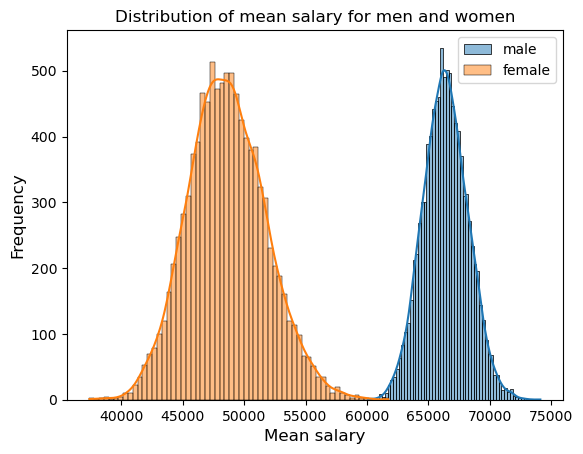

In [20]:
#Distribution plots for bootstrapped mean data
ax = sns.histplot(data = bootstrap_gender, x='mean male salary', kde='True', label = 'male')
sns.histplot(data = bootstrap_gender, x='mean female salary', kde='True',ax=ax, label = 'female')
ax.set(title = "Distribution of mean salary for men and women")
ax.set_xlabel('Mean salary',fontsize=12)
ax.set_ylabel('Frequency',fontsize=12)
ax.legend()
plt.show()

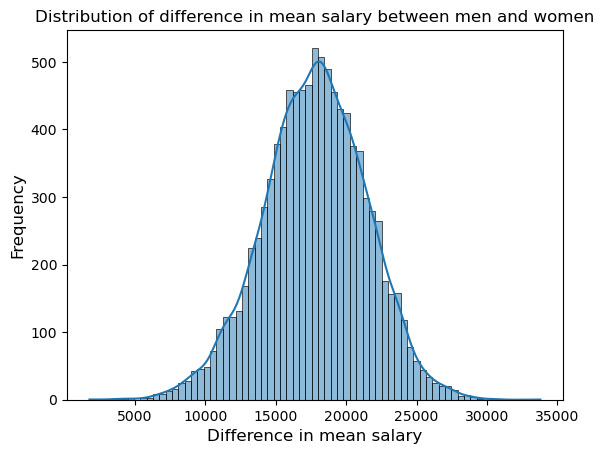

In [21]:
#Distribution plots for bootstrapped difference in mean
ax = sns.histplot(data = bootstrap_gender, x='difference mean salary', kde='True')
ax.set(title = "Distribution of difference in mean salary between men and women")
ax.set_xlabel('Difference in mean salary',fontsize=12)
ax.set_ylabel('Frequency',fontsize=12)
plt.show()

In [22]:
#Create new 'normalized' key in bootstrap_gender
bootstrap_gender['normalized']=[]
min_diff = min(bootstrap_gender['difference mean salary'])      #minimum value in differences in mean salaries
max_diff = max(bootstrap_gender['difference mean salary'])     #maximum value in differences in mean salaries

#iterate through the values of differences in mean, normalize, and append into bootstrap_gender
for value in bootstrap_gender['difference mean salary']:
    bootstrap_gender['normalized'].append((value-min_diff)/(max_diff-min_diff))

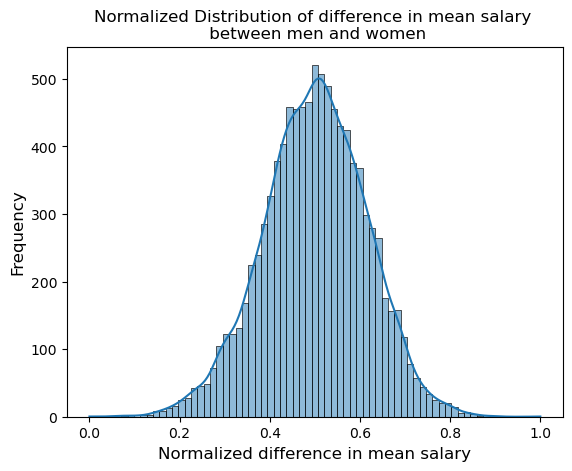

In [23]:
#Plot normalized difference in mean salary between men and women
ax = sns.histplot(data = bootstrap_gender, x='normalized', kde='True')
ax.set(title = "Normalized Distribution of difference in mean salary \n between men and women")
ax.set_xlabel('Normalized difference in mean salary',fontsize=12)
ax.set_ylabel('Frequency',fontsize=12)
plt.show()

### T-test on bootstrapped data

In [24]:
#Bartlett's test to check homogeneity of variance between groups
stat, p_value = stats.bartlett(bootstrap_gender['mean male salary'], bootstrap_gender['mean female salary'])
print ("t-test: t = %g  p = %g" % (stat, p_value))

#Check if we accept or reject Ho:
alpha = 0.05
if p_value < alpha:
    print('We reject the null hypothesis, the variances of the groups are statistically different')
else:
    print('We accept the null hypothesis, the variances of the groups are not statistically different')

t-test: t = 2874.33  p = 0
We reject the null hypothesis, the variances of the groups are statistically different


In [25]:
#Welch's T-test to get t_value and p_value on bootstrapped data
t_stat, p_value = stats.ttest_ind(bootstrap_gender['mean male salary'], bootstrap_gender['mean female salary'], equal_var=False)
print ("t-test: t = %g  p = %g" % (t_stat, p_value))

#Check if we accept or reject Ho:
alpha = 0.05
if p_value < alpha:
    print('We reject the null hypothesis, the means of the two groups are statistically different')
else:
    print('We accept the null hypothesis, the means of the two groups are not statistically different')

t-test: t = 486.37  p = 0
We reject the null hypothesis, the means of the two groups are statistically different


## Estimating the difference between average salary of Bachelor's degree, Masters' degree, and Doctoral degree holders

### descriptive statistics

In [26]:
#Create a copy of columns Q8(education level) and Q29(salaries) from dataFrame df and assign to df_degree_salary
df_degree_salary = df[['Q8','Q29']].copy()

#Filter out rows that are not 'Bachelor's degree','Master's degree', or 'Doctoral degree' in columns 'Q8'
df_degree_salary = df_degree_salary[(df_degree_salary['Q8']=='Bachelor’s degree')
                                    |(df_degree_salary['Q8']=='Master’s degree')
                                    |(df_degree_salary['Q8']=='Doctoral degree')]

In [27]:
#Calculate IQR to compute lower and upper bound to tesst outlier removal
Q1 = df_degree_salary['Q29'].quantile(0.25)
Q3 = df_degree_salary['Q29'].quantile(0.75)
lower_bound = Q1-1.5*(Q3-Q1)
upper_bound = Q3+1.5*(Q3-Q1)
print(f'Q1: {Q1}, Q3: {Q3}, lower_bound: {lower_bound}, upper_bound: {upper_bound}')

Q1: 5000.0, Q3: 80000.0, lower_bound: -107500.0, upper_bound: 192500.0


In [28]:
#Remove outliers and include only salaries between the lower_bound and upper_bound in new variable df_degree_salary_filtered
df_degree_salary_filtered = df_degree_salary[(df_degree_salary['Q29'] >= lower_bound)&(df_degree_salary['Q29'] <= upper_bound)]
df_degree_salary.head()

,Q8,Q29
1,Bachelor’s degree,125000
2,Doctoral degree,125000
3,Doctoral degree,250000
4,Master’s degree,250000
5,Master’s degree,200000


In [29]:
#Filter each kind of degree and separate it into different corresponding dataframes
df_bachelors_salary = df_degree_salary[df_degree_salary['Q8']=='Bachelor’s degree']
df_masters_salary = df_degree_salary[df_degree_salary['Q8']=='Master’s degree']
df_doctoral_salary = df_degree_salary[df_degree_salary['Q8']=='Doctoral degree']

#Create dataframe bachelors-only, masters-only, and doctoral-only dataframes once outliers are removed
df_bachelors_salary_filtered = df_degree_salary_filtered[df_degree_salary_filtered['Q8']=='Bachelor’s degree']
df_masters_salary_filtered = df_degree_salary_filtered[df_degree_salary_filtered['Q8']=='Master’s degree']
df_doctoral_salary_filtered = df_degree_salary_filtered[df_degree_salary_filtered['Q8']=='Doctoral degree']

In [30]:
#Get proportion of data that are outliers in bachelor's degree instances
bachelors_instances = df_bachelors_salary.shape[0] 
bachelors_instances_filtered = df_bachelors_salary_filtered.shape[0]
outlier_proportion_b = (bachelors_instances-bachelors_instances_filtered)/bachelors_instances
print(f"outliers make up {round(outlier_proportion_b*100,2)}% of bachelor's degree holders within the dataset")

outliers make up 6.83% of bachelor's degree holders within the dataset


In [31]:
#Get proportion of data that are outliers in masters's degree instances
masters_instances = df_masters_salary.shape[0] 
masters_instances_filtered = df_masters_salary_filtered.shape[0]
outlier_proportion_m = (masters_instances-masters_instances_filtered)/masters_instances
print(f"outliers make up {round(outlier_proportion_m*100,2)}% of master's degree holders within the dataset")

outliers make up 9.34% of master's degree holders within the dataset


In [32]:
#Get proportion of data that are outliers in doctoral degree instances
doctoral_instances = df_doctoral_salary.shape[0] 
doctoral_instances_filtered = df_doctoral_salary_filtered.shape[0]
outlier_proportion_d = (doctoral_instances-doctoral_instances_filtered)/doctoral_instances
print(f"outliers make up {round(outlier_proportion_d*100,2)}% of doctoral degree holders within the dataset")

outliers make up 13.71% of doctoral degree holders within the dataset


Outliers in the bachelor's degree instances make up 6.83% of the collected data,
outliers in the master's degree instances make up 9.34% of the collected data, and outliers in the doctoral degree instances make up 13.71% of the collected data.
Therefore I decided to keep the outliers as removing them may affect testing whether the mean salaries are different based on a person's highest education level

In [33]:
#Descriptive statistics for bachelor's degree holders
df_bachelors_salary.describe()

,Q29
count,2005.000000
mean,53855.112219
std,115708.228065
min,1000.000000
25%,3000.000000
50%,15000.000000
75%,60000.000000
max,1000000.000000


In [34]:
#Descriptive statistics for master's degree holders
df_masters_salary.describe()

,Q29
count,3567.000000
mean,65620.128960
std,108747.716468
min,1000.000000
25%,7500.000000
50%,30000.000000
75%,80000.000000
max,1000000.000000


In [35]:
#Descriptive statistics for doctoral degree holders
df_doctoral_salary.describe()

,Q29
count,1349.000000
mean,84376.945886
std,131631.895507
min,1000.000000
25%,7500.000000
50%,50000.000000
75%,100000.000000
max,1000000.000000


### ANOVA test

In [36]:
#Reassign series from column 'Q29' to its respective new variables to feed into ANOVA test
bachelors_salary = df_bachelors_salary['Q29']
masters_salary = df_masters_salary['Q29']
doctoral_salary = df_doctoral_salary['Q29']

#Bartlett's test to check homogeneity of variance between groups
stat, p_value = stats.bartlett(bachelors_salary,masters_salary,doctoral_salary)

#Check if we accept or reject Ho:
alpha = 0.05
if p_value < alpha:
    print('We reject the null hypothesis, the variances of the groups are statistically different')
else:
    print('We accept the null hypothesis, the variances of the groups are not statistically different')

We reject the null hypothesis, the variances of the groups are statistically different


In [37]:
#As the results from the Bartlett's test shows that the variances are significantly different,
#we proceed with the Welch's ANOVA
welch_anova = pg.welch_anova(data=df_degree_salary, dv='Q29', between='Q8')
welch_anova

,Source,ddof1,ddof2,F,p-unc,np2
0,Q8,2,3144.454303,23.968826,4.666820e-11,0.008073


In [38]:
#One-way ANOVA test to get f_statistic and p_value (just to compare with Welch's ANOVA)
f_statistic, p_value = stats.f_oneway(bachelors_salary, masters_salary, doctoral_salary)
print ("ANOVA: F = %g  p = %g" % (f_statistic, p_value))

#Check if we accept or reject Ho: 
alpha = 0.05
if p_value < alpha:
    print('We reject the null hypothesis, the means of the three groups are statistically different')
else:
    print('We accept the null hypothesis, the means of the three groups are not statistically different')

ANOVA: F = 28.1525  p = 6.65265e-13
We reject the null hypothesis, the means of the three groups are statistically different


### Bootstrapping

In [39]:
#Bootstrapping
replications = 10000   #number of replications
bootstrap_size_coefficient = 0.66    #range 0 to 1
bootstrap_size_bachelors = round(len(bachelors_salary) * bootstrap_size_coefficient)    #number of instances sampled in each replication for bachelor's
bootstrap_size_masters = round(len(masters_salary) * bootstrap_size_coefficient)    #number of instances sampled in each replication for master's
bootstrap_size_doctoral = round(len(doctoral_salary) * bootstrap_size_coefficient)    #number of instances sampled in each replication for doctoral

#create dictionary to store bootstrapped mean salaries for each education level, and differences in mean salaries between the education levels
bootstrap_degree = {}
bootstrap_degree['mean bachelors salary'] = []
bootstrap_degree['mean masters salary'] = []
bootstrap_degree['mean doctoral salary'] = []
bootstrap_degree['difference bac-mas salary'] = []
bootstrap_degree['difference bac-doc salary'] = []
bootstrap_degree['difference mas-doc salary'] = []

#set up for loop to iterate from 0 to replications specified above
#each loop appends mean salaries for each education level, and differences in mean salaries to the respective keys in bootstrap_degree 
for x in range(replications):
    bachelors_samples = np.random.choice(bachelors_salary, size= bootstrap_size_bachelors, replace=True)
    mean_salary_b = bachelors_samples.mean()
    bootstrap_degree['mean bachelors salary'].append(mean_salary_b)
    
    masters_samples = np.random.choice(masters_salary, size= bootstrap_size_masters, replace=True)
    mean_salary_m = masters_samples.mean()
    bootstrap_degree['mean masters salary'].append(mean_salary_m)

    doctoral_samples = np.random.choice(doctoral_salary, size= bootstrap_size_doctoral, replace=True)
    mean_salary_d = doctoral_samples.mean()
    bootstrap_degree['mean doctoral salary'].append(mean_salary_d)
    
    bootstrap_degree['difference bac-mas salary'].append(mean_salary_m - mean_salary_b)
    bootstrap_degree['difference mas-doc salary'].append(mean_salary_d - mean_salary_m)
    bootstrap_degree['difference bac-doc salary'].append(mean_salary_d - mean_salary_b)

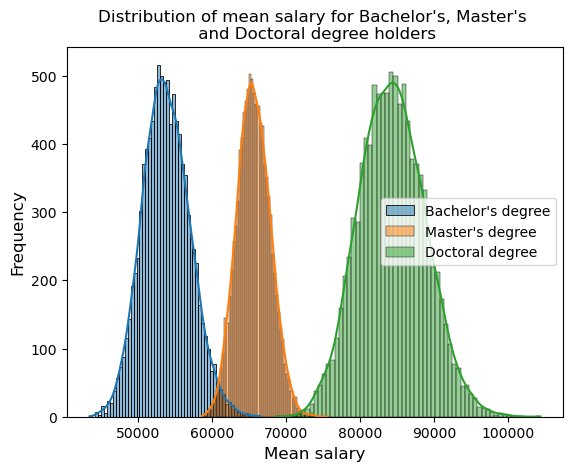

In [40]:
#Distribution plots for bootstrapped mean salaries based on education levels
ax = sns.histplot(data = bootstrap_degree, x='mean bachelors salary', kde='True', label = "Bachelor's degree")
sns.histplot(data = bootstrap_degree, x='mean masters salary', kde='True', label = "Master's degree")
sns.histplot(data = bootstrap_degree, x='mean doctoral salary', kde='True', label = "Doctoral degree")
ax.set(title = "Distribution of mean salary for Bachelor's, Master's \n and Doctoral degree holders")
ax.set_xlabel('Mean salary',fontsize=12)
ax.set_ylabel('Frequency',fontsize=12)
ax.legend()
plt.show()

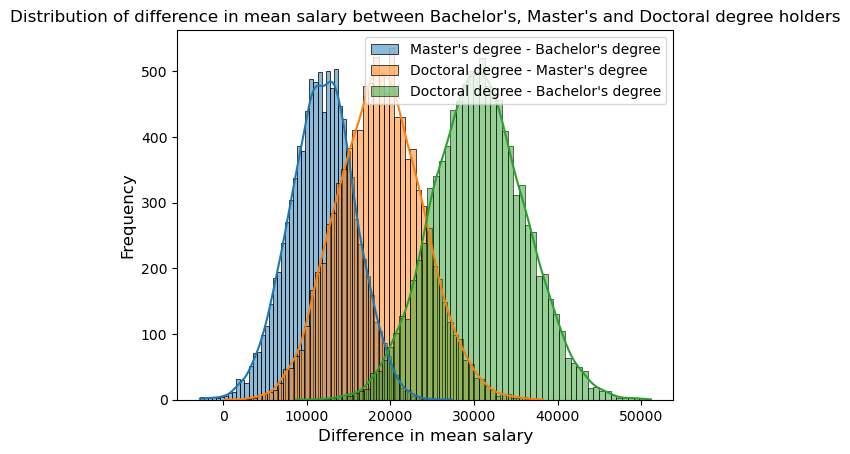

In [41]:
#Distribution plots for differences in mean salaries based on education levels
ax = sns.histplot(data = bootstrap_degree, x='difference bac-mas salary', kde='True', label = "Master's degree - Bachelor's degree")
sns.histplot(data = bootstrap_degree, x='difference mas-doc salary', kde='True', label = "Doctoral degree - Master's degree")
sns.histplot(data = bootstrap_degree, x='difference bac-doc salary', kde='True', label = "Doctoral degree - Bachelor's degree")
ax.set(title = "Distribution of difference in mean salary between Bachelor's, Master's and Doctoral degree holders")
ax.set_xlabel('Difference in mean salary',fontsize=12)
ax.set_ylabel('Frequency',fontsize=12)
ax.legend()
plt.show()

In [42]:
#Create new normalized keys for each category in bootstrap_degree
bootstrap_degree["normalized Master's - Bachelor's"]=[]
bootstrap_degree["normalized Doctoral - Master's"]=[]
bootstrap_degree["normalized Doctoral - Bachelor's"]=[]

#Normalize Master's - Bachelor's
min_diff_mas_bac = min(bootstrap_degree['difference bac-mas salary'])
max_diff_mas_bac = max(bootstrap_degree['difference bac-mas salary'])
for value in bootstrap_degree['difference bac-mas salary']:
    bootstrap_degree["normalized Master's - Bachelor's"].append((value-min_diff_mas_bac)/(max_diff_mas_bac-min_diff_mas_bac))

#Normalize Doctoral - Master's
min_diff_doc_mas = min(bootstrap_degree['difference bac-mas salary'])
max_diff_doc_mas = max(bootstrap_degree['difference bac-mas salary'])
for value in bootstrap_degree['difference mas-doc salary']:
    bootstrap_degree["normalized Doctoral - Master's"].append((value-min_diff_doc_mas)/(max_diff_doc_mas-min_diff_doc_mas))

#Normalize Doctoral - Bachelor's
min_diff_doc_bac = min(bootstrap_degree['difference bac-mas salary'])
max_diff_doc_bac = max(bootstrap_degree['difference bac-mas salary'])
for value in bootstrap_degree['difference bac-doc salary']:
    bootstrap_degree["normalized Doctoral - Bachelor's"].append((value-min_diff_doc_bac)/(max_diff_doc_bac-min_diff_doc_bac))

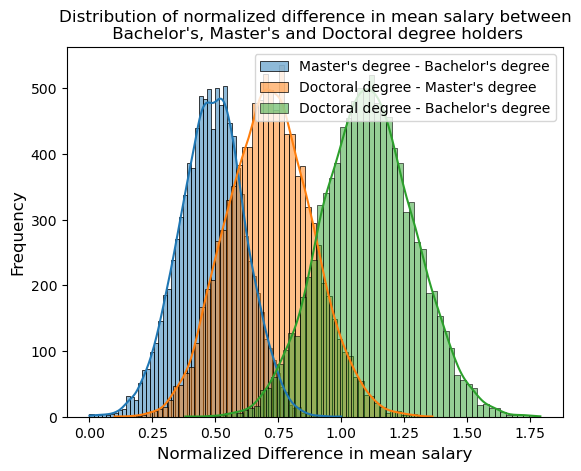

In [43]:
#Plot normalized difference in mean salary between different degree holders
ax = sns.histplot(data = bootstrap_degree, x="normalized Master's - Bachelor's", kde='True', label = "Master's degree - Bachelor's degree")
sns.histplot(data = bootstrap_degree, x="normalized Doctoral - Master's", kde='True', label = "Doctoral degree - Master's degree")
sns.histplot(data = bootstrap_degree, x="normalized Doctoral - Bachelor's", kde='True', label = "Doctoral degree - Bachelor's degree")
ax.set(title = "Distribution of normalized difference in mean salary between\n Bachelor's, Master's and Doctoral degree holders")
ax.set_xlabel('Normalized Difference in mean salary',fontsize=12)
ax.set_ylabel('Frequency',fontsize=12)
ax.legend()
plt.show()

### ANOVA test on bootstrapped data

In [44]:
#ANOVA test to get f_statistic and p_value
f_statistic, p_value = stats.f_oneway(bootstrap_degree["mean bachelors salary"], bootstrap_degree["mean masters salary"], bootstrap_degree["mean doctoral salary"])
print ("ANOVA: F = %g  p = %g" % (f_statistic, p_value))

#Check if we accept or reject Ho:
alpha = 0.05
if p_value < alpha:
    print('We reject the null hypothesis, the means of the two groups are statistically different')
else:
    print('We accept the null hypothesis, the means of the two groups are not statistically different')

ANOVA: F = 202986  p = 0
We reject the null hypothesis, the means of the two groups are statistically different
